In [1]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.master(os.getenv('SPARK_MASTER_ADDRESS')).appName("Spark-application").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 22:08:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sc = spark._jsc.sc()
n_workers = len([executor.host()for executor in sc.statusTracker().getExecutorInfos() ])-1 
print(n_workers)

0


In [3]:
!echo $SPARK_MASTER_ADDRESS
!echo $SPARK_MASTER_OOD_ADDRESS
!echo $SPARK_WORKER1_OOD_ADDRESS
!echo $SPARK_WORKER2_OOD_ADDRESS

spark://notch081.ipoib.int.chpc.utah.edu:7077
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8080
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8081
https://ondemand-class.chpc.utah.edu/rnode/notch082.ipoib.int.chpc.utah.edu/8081


In [4]:
spark = SparkSession.builder \
    .master("spark://notch081.ipoib.int.chpc.utah.edu:7077") \
    .appName("MyAPP") \
    .getOrCreate()

24/04/30 22:08:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Stockwave to train LSTM model on 10 stocks

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [28]:
file_list = [file for file in os.listdir('data_torun') if file.endswith('.csv')]

In [29]:
file_list

['CHD_data.csv',
 'CVX_data.csv',
 'DUK_data.csv',
 'DVA_data.csv',
 'EQR_data.csv',
 'ESS_data.csv',
 'FOX_data.csv',
 'GILD_data.csv',
 'GPS_data.csv',
 'HAL_data.csv']

#### Feature Engineering to add "EMA" and "RSI" columns

In [30]:
from pyspark.sql.functions import col, lag, mean, when, avg, stddev
from pyspark.sql.window import Window

# Exponential Moving Average (EMA)
def add_ema(df, alpha=0.2):
    window_spec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
    df = df.withColumn("EMA", mean(col("close")).over(window_spec))
    return df

# Relative Strength Index (RSI)
def add_rsi(df, window=14):
    delta = col('close') - lag('close').over(Window.orderBy('date'))
    gain = when(delta > 0, delta).otherwise(0)
    loss = when(delta < 0, -delta).otherwise(0)
    avg_gain = mean(gain).over(Window.orderBy('date').rowsBetween(-window, Window.currentRow))
    avg_loss = mean(loss).over(Window.orderBy('date').rowsBetween(-window, Window.currentRow))
    rs = avg_gain / avg_loss
    df = df.withColumn('RSI', 100 - (100 / (1 + rs)))
    return df

#### Data Cleaning: Removing Null values and Outliers

In [31]:
dataframes_dict = {}
directory = 'data_torun/'
for filename in file_list:
    # Load the CSV file into a DataFrame
    file_path = os.path.join(directory, filename)
    stock1 = spark.read.csv(file_path,header=True)

    # Type Casting
    from pyspark.sql.functions import to_date
    from pyspark.sql.types import *
    
    stock1 = stock1.withColumn("date", to_date(stock1["date"]).cast(DateType()))
    stock1 = stock1.withColumn("open", (stock1["open"]).cast(FloatType()))
    stock1 = stock1.withColumn("high", (stock1["high"]).cast(FloatType()))
    stock1 = stock1.withColumn("low", (stock1["low"]).cast(FloatType()))
    stock1 = stock1.withColumn("close", (stock1["close"]).cast(FloatType()))
    stock1 = stock1.withColumn("volume", (stock1["volume"]).cast(IntegerType()))

    # Feature Engineering
    stock1 = add_ema(stock1)
    stock1 = add_rsi(stock1)

    # Drop if there are any null values present
    stock1 = stock1.na.drop()

    # Remove outliers
    # Calculate mean and standard deviation
    for column in ["open", "close", "high", "low", "volume","EMA","RSI"]:
        mean_val = stock1.select(mean(col(column)).alias("mean")).collect()[0]["mean"]
        stddev_val = stock1.select(stddev(col(column)).alias("stddev")).collect()[0]["stddev"]
    
        # Set the threshold for outliers (3 standard deviations away from the mean)
        threshold = 3 * stddev_val
        
        # Filter out rows with values outside the threshold
        stock = stock1.filter((col(column) >= mean_val - threshold) & (col(column) <= mean_val + threshold))

    stock1 = stock1.na.drop()

    # Convert to pandas
    df = stock.toPandas()

    df = df.drop(columns= ['date', 'Name', 'volume'])
    
    # Extract the filename without '_data.csv'
    key = filename.replace('_data.csv', '')
    
    # Store the DataFrame in the dictionary
    dataframes_dict[key] = df

24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 22:36:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 2

In [32]:
dataframes_dict.keys()

dict_keys(['CHD', 'CVX', 'DUK', 'DVA', 'EQR', 'ESS', 'FOX', 'GILD', 'GPS', 'HAL'])

In [33]:
dataframes_dict.values()

dict_values([           open       high        low      close        EMA        RSI
0     29.815001  30.025000  29.719999  29.990000  29.956667  41.176365
1     29.950001  30.084999  29.674999  29.809999  29.920000  28.925516
2     29.790001  29.915001  29.639999  29.639999  29.864000  22.580558
3     29.695000  30.165001  29.645000  29.940001  29.876667  44.186051
4     30.000000  30.244900  29.820000  30.215000  29.925000  55.555540
...         ...        ...        ...        ...        ...        ...
1252  48.910000  49.029999  48.430000  48.490002  41.176490  37.103155
1253  48.139999  48.139999  46.130001  46.330002  41.180593  27.581100
1254  46.619999  48.790001  46.619999  47.419998  41.185557  39.361666
1255  46.910000  48.965000  46.740002  47.869999  41.190870  41.085249
1256  48.380001  48.840000  47.349998  47.369999  41.195778  33.769611

[1257 rows x 6 columns],             open        high         low       close         EMA        RSI
0     115.430000  115.839996  114

#### Rearranging data to a window size of 5 for LSTM

In [34]:
def df_to_X_y2(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][3] #close value is y 
        y.append(label)
    return np.array(X), np.array(y)

X_y_dict = {}

for key, df in dataframes_dict.items():
    # Apply df_to_X_y2 function to the current DataFrame
    X, y = df_to_X_y2(df)
    # Store X, y pair in the new dictionary
    X_y_dict[key] = (X, y)

#### Splitting data into Train, Test and Validation

In [35]:
# Initialize empty dictionaries to store data splits
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}
y_train_dict = {}
y_val_dict = {}
y_test_dict = {}

# Loop through each entry in X_y_dict
for key, (X, y) in X_y_dict.items():
    # Calculate lengths of data splits
    data_len = len(X)
    training_data_len = int(np.ceil(data_len * 0.9))
    val_data_len = int(np.ceil(data_len * 0.05))
    test_data_len = data_len - training_data_len - val_data_len

    # Split the data
    X_train = X[:training_data_len]
    X_val = X[training_data_len:training_data_len + val_data_len]
    X_test = X[training_data_len + val_data_len:]
    
    y_train = y[:training_data_len]
    y_val = y[training_data_len:training_data_len + val_data_len]
    y_test = y[training_data_len + val_data_len:]
    
    # Store the splits in the dictionaries
    X_train_dict[key] = X_train
    X_val_dict[key] = X_val
    X_test_dict[key] = X_test
    y_train_dict[key] = y_train
    y_val_dict[key] = y_val
    y_test_dict[key] = y_test


#### Standardization (scaling the data)

In [36]:
def preprocess_X(X, means, stds):
    X[:, :, 0] = (X[:, :, 0] - means['open']) / stds['open']
    X[:, :, 1] = (X[:, :, 1] - means['high']) / stds['high']
    X[:, :, 2] = (X[:, :, 2] - means['low']) / stds['low']
    X[:, :, 3] = (X[:, :, 3] - means['close']) / stds['close']
    X[:, :, 4] = (X[:, :, 4] - means['EMA']) / stds['EMA']
    X[:, :, 5] = (X[:, :, 5] - means['RSI']) / stds['RSI']
    return X

def preprocess_y(y, mean, std):
    y[:] = (y[:] - mean) / std
    return y

In [37]:
# Initialize dictionaries to store means and stds for each key
means_dict = {}
stds_dict = {}

# Loop through each key in X_train_dict
for key, X_train in X_train_dict.items():
    # Calculate means and stds for each feature
    open_mean = np.mean(X_train[:, :, 0])
    open_std = np.std(X_train[:, :, 0])

    high_mean = np.mean(X_train[:, :, 1])
    high_std = np.std(X_train[:, :, 1])

    low_mean = np.mean(X_train[:, :, 2])
    low_std = np.std(X_train[:, :, 2])

    close_mean = np.mean(X_train[:, :, 3])
    close_std = np.std(X_train[:, :, 3])

    ema_mean = np.mean(X_train[:, :, 4])
    ema_std = np.std(X_train[:, :, 4])

    rsi_mean = np.mean(X_train[:, :, 5])
    rsi_std = np.std(X_train[:, :, 5])
    
    # Store means and stds for the current key
    means_dict[key] = {'open': open_mean, 'high': high_mean, 'low': low_mean, 'close': close_mean,'EMA':ema_mean,'RSI':rsi_mean}
    stds_dict[key] = {'open': open_std, 'high': high_std, 'low': low_std, 'close': close_std,'EMA':ema_std,'RSI':rsi_std}

    # Preprocess X_train_dict[key]
    X_train_dict[key] = preprocess_X(X_train_dict[key], means_dict[key], stds_dict[key])

    # Preprocess X_val_dict[key]
    X_val_dict[key] = preprocess_X(X_val_dict[key], means_dict[key], stds_dict[key])

    # Preprocess X_test_dict[key]
    X_test_dict[key] = preprocess_X(X_test_dict[key], means_dict[key], stds_dict[key])

    # Preprocess y_train_dict[key]
    y_train_dict[key] = preprocess_y(y_train_dict[key], close_mean, close_std)

    # Preprocess y_val_dict[key]
    y_val_dict[key] = preprocess_y(y_val_dict[key], close_mean, close_std)

    # Preprocess y_test_dict[key]
    y_test_dict[key] = preprocess_y(y_test_dict[key], close_mean, close_std)


In [38]:
import json

if not os.path.exists('means_torun'):
    os.makedirs('means_torun')
if not os.path.exists('stds_torun'):
    os.makedirs('stds_torun')

# Save dictionary to a JSON file
with open('means_torun/means_dict_torun.json', 'w') as f:
    json.dump(means_dict, f)

with open('stds_torun/stds_dict_torun.json', 'w') as f:
    json.dump(stds_dict, f)


#### Model development

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

2024-04-30 22:14:16.970540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 22:14:22.550119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
def create_lstm_model():
    model = Sequential()
    model.add(InputLayer((5, 6)))  # window_size is 5 and features are 6
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(Dense(1))
    return model

#### Training and Saving the model

In [24]:
# Loop through each key in the dictionaries
models_dict = {}

for key in X_train_dict.keys():
    # Load the data for the current key
    X_train = X_train_dict[key]
    y_train = y_train_dict[key]
    X_val = X_val_dict[key]
    y_val = y_val_dict[key]

    # # Train the model
    # print(f'*****************************************************training for : {key}')
    model = create_lstm_model()
    cp = ModelCheckpoint(f'modelstorun_/{key}_model.keras', save_best_only=True)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])
    models_dict[key] = model


2024-04-30 22:15:16.265102: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-30 22:15:16.265227: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: notch081
2024-04-30 22:15:16.265244: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: notch081
2024-04-30 22:15:16.265410: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-04-30 22:15:16.265444: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-04-30 22:15:16.265457: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2358 - root_mean_squared_error: 0.4640 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537 - root_mean_squared_error: 0.2317 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0279 - root_mean_squared_error: 0.1668 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0340 - root_mean_squared_error: 0.1842 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0342 - root_mean_squared_error: 0.1845 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0313 - root_mean_squared_error: 0.1766 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

#### Inverse scaling for plotting predictions

In [25]:
def inverse_scaling(arr, mean, std):
    return arr * std + mean

#### Plotting and Evaluation metrics for Test Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
MAE for EQR: 0.06892845280749024
MSE for EQR: 0.007866406093486664
RMSE for EQR: 0.08869276235120126
R2 Score for EQR: 0.9512517255374611


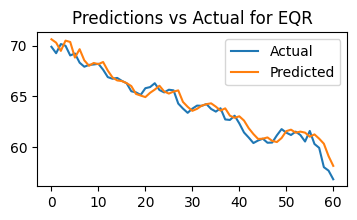

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictions_dict = {}
y_test_dict_inverse_scaled = {}
mae_dict = {}
mse_dict = {}
rmse_dict = {}
r2_dict = {}

for key in X_test_dict.keys():
    # Make predictions for the current key
    predictions = models_dict[key].predict(X_test_dict[key])
    # Inverse scale the predictions
    y_pred = inverse_scaling(predictions, means_dict[key]['close'], stds_dict[key]['close'])
    # Inverse scale y_test
    y_test_inverse_scaled = inverse_scaling(y_test_dict[key], means_dict[key]['close'], stds_dict[key]['close'])

    # Calculate MAE, MSE, RMSE, and R2 score for the current key
    mae = mean_absolute_error(y_test_dict[key], predictions)
    mse = mean_squared_error(y_test_dict[key], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_dict[key], predictions)

    # Print the metrics
    print(f"MAE for {key}: {mae}")
    print(f"MSE for {key}: {mse}")
    print(f"RMSE for {key}: {rmse}")
    print(f"R2 Score for {key}: {r2}")

    # Store metrics in dictionaries
    predictions_dict[key] = y_pred
    y_test_dict_inverse_scaled[key] = y_test_inverse_scaled
    mae_dict[key] = mae
    mse_dict[key] = mse
    rmse_dict[key] = rmse
    r2_dict[key] = r2

    # Plot the results for the current key
    plt.figure(figsize=(4, 2))
    plt.plot(y_test_inverse_scaled, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"Predictions vs Actual for {key}")
    plt.legend()
    plt.show()
